<a href="https://colab.research.google.com/github/Nirzaree/Detecting-Roads-from-Satellite-Images/blob/master/Road_Detection_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmentation of Road from Satellite imagery

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importing Libraries

In [36]:
!pip install tensorboardcolab
!pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-1dv6qqyq
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-1dv6qqyq
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 50 kB 2.8 MB/s 
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-py3-none-any.whl size=33810 sha256=52f36094aaf2590d246f168a1566b2a76430d213d9dfff62bb85cd3da1eceed1
  Stored in directory: /tmp/pip-ephem-wheel-cache-yn_fg2nc/wheels/02/cd/18/61c0bbb8766acfec68f9d20618886b7b38dfeeb95865b6ba00
Successfully built segmentation-models


In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import tensorflow as tf
import pandas as pd
from keras.models import Model, load_model
from skimage.morphology import label
import pickle
import tensorflow.keras.backend as K

from matplotlib import pyplot as plt
from tqdm import tqdm_notebook
import random
from skimage.io import imread, imshow, imread_collection, concatenate_images
from matplotlib import pyplot as plt
import h5py

seed = 56

## Loading Data

In [52]:
IMAGE_HEIGHT = IMAGE_WIDTH = 256
NUM_CHANNELS = 3
image_file = '/content/drive/MyDrive/Data/MasachusettsRoads/road_images.h5py'
mask_file = '/content/drive/MyDrive/Data/MasachusettsRoads/road_masks.h5py'

In [53]:
hfile = h5py.File(image_file, 'r')
n1 = hfile.get('images')
images = np.array(n1[:1500,:,:,])
print(images.shape)
hfile.close()

(1500, 256, 256, 3)


In [54]:
hfile = h5py.File(mask_file, 'r')
hfile.keys()

<KeysViewHDF5 ['masks']>

In [55]:
n1 = hfile.get('masks')
masks = np.array(n1[:1500,:,])
print(masks.shape)
print("Unique elements in the train mask:", np.unique(masks))
hfile.close()

(1500, 256, 256)
Unique elements in the train mask: [  0 255]


## Displaying few Samples

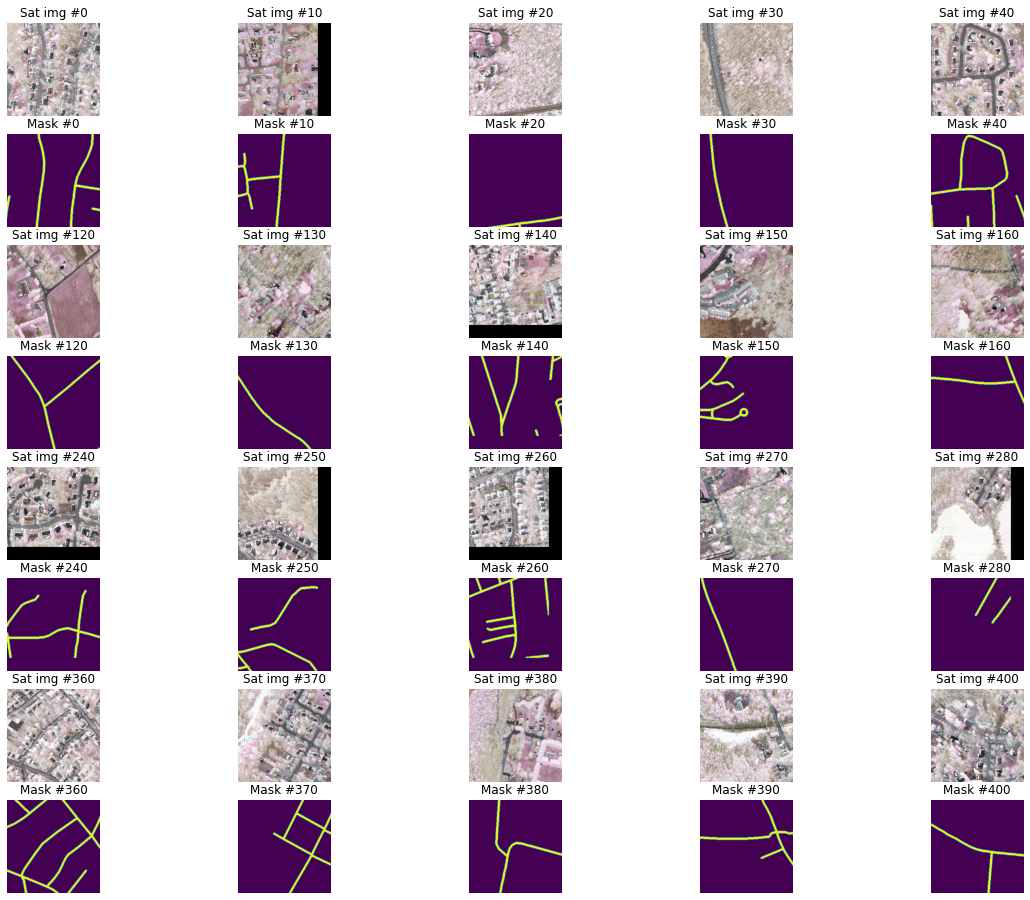

In [7]:
plt.figure(figsize=(20,16))
x, y = 5,4
for i in range(y):  
    for j in range(x):
        plt.subplot(y*2, x, i*2*x+j+1)
        pos = i*120 + j*10
        plt.imshow((images[pos] * 255).astype(np.uint8))
        plt.title('Sat img #{}'.format(pos))
        plt.axis('off')
        plt.subplot(y*2, x, (i*2+1)*x+j+1)
           
        #We display the associated mask we just generated above with the training image
        plt.imshow(masks[pos])
        plt.title('Mask #{}'.format(pos))
        plt.axis('off')
        
plt.show()

In [56]:
masks = np.expand_dims(masks, -1)

## Defining Custom Loss functions and accuracy Metric.

In [9]:
#Source: https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2
from keras import backend as K
def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  
  return iou

In [10]:
def dice_coef(y_true, y_pred, smooth = 1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def soft_dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [57]:
print(masks.shape)
print(images.shape)

(1500, 256, 256, 1)
(1500, 256, 256, 3)


## Splitting data

In [58]:
from sklearn.model_selection import train_test_split
train_images, test_images, train_masks, test_masks = train_test_split(images, masks, test_size=0.2, random_state=seed)
del images, masks
print("TRAIN SET")
print(train_images.shape)
print(train_masks.shape)
print("TEST SET")
print(test_images.shape)
print(test_masks.shape)

TRAIN SET
(1200, 256, 256, 3)
(1200, 256, 256, 1)
TEST SET
(300, 256, 256, 3)
(300, 256, 256, 1)


## Defining Our Model

In [13]:
from keras.models import Model, load_model
import tensorflow as tf
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import optimizers
from keras.layers import BatchNormalization
from tensorflow.keras.metrics import MeanIoU
import keras

In [14]:
inputs = Input((IMAGE_HEIGHT, IMAGE_WIDTH, 3))
s = Lambda(lambda x: x / 255) (inputs)

conv1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
conv1 = BatchNormalization() (conv1)
conv1 = Dropout(0.1) (conv1)
conv1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1)
conv1 = BatchNormalization() (conv1)
pooling1 = MaxPooling2D((2, 2)) (conv1)

conv2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling1)
conv2 = BatchNormalization() (conv2)
conv2 = Dropout(0.1) (conv2)
conv2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2)
conv2 = BatchNormalization() (conv2)
pooling2 = MaxPooling2D((2, 2)) (conv2)

conv3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling2)
conv3 = BatchNormalization() (conv3)
conv3 = Dropout(0.2) (conv3)
conv3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3)
conv3 = BatchNormalization() (conv3)
pooling3 = MaxPooling2D((2, 2)) (conv3)

conv4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling3)
conv4 = BatchNormalization() (conv4)
conv4 = Dropout(0.2) (conv4)
conv4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4)
conv4 = BatchNormalization() (conv4)
pooling4 = MaxPooling2D(pool_size=(2, 2)) (conv4)

conv5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pooling4)
conv5 = BatchNormalization() (conv5)
conv5 = Dropout(0.3) (conv5)
conv5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv5)
conv5 = BatchNormalization() (conv5)


upsample6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (conv5)
upsample6 = concatenate([upsample6, conv4])
conv6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample6)
conv6 = BatchNormalization() (conv6)
conv6 = Dropout(0.2) (conv6)
conv6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv6)
conv6 = BatchNormalization() (conv6)

upsample7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (conv6)
upsample7 = concatenate([upsample7, conv3])
conv7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample7)
conv7 = BatchNormalization() (conv7)
conv7 = Dropout(0.2) (conv7)
conv7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv7)
conv7 = BatchNormalization() (conv7)

upsample8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (conv7)
upsample8 = concatenate([upsample8, conv2])
conv8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample8)
conv8 = BatchNormalization() (conv8)
conv8 = Dropout(0.1) (conv8)
conv8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv8)
conv8 = BatchNormalization() (conv8)

upsample9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (conv8)
upsample9 = concatenate([upsample9, conv1], axis=3)
conv9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (upsample9)
conv9 = BatchNormalization() (conv9)
conv9 = Dropout(0.1) (conv9)
conv9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv9)
conv9 = BatchNormalization() (conv9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (conv9)

model = Model(inputs=[inputs], outputs=[outputs])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [38]:
from segmentation_models import Unet

Segmentation Models: using `keras` framework.


In [59]:
import segmentation_models as sm

sm.set_framework('tf.keras')

sm.framework()

'tf.keras'

In [60]:
model = Unet(backbone_name = 'efficientnetb0', encoder_weights='imagenet', encoder_freeze = False)



In [61]:
model.compile(
      optimizer=opt,
      loss=soft_dice_loss,
      metrics=[iou_coef])

In [62]:
EPOCHS = 100
LEARNING_RATE = 0.0001
BATCH_SIZE = 32

In [63]:
history = model.fit(train_images,
                    train_masks/255,
                    validation_split = 0.1,
                    epochs=EPOCHS,
                    batch_size = BATCH_SIZE,
                    callbacks = [checkpointer, earlystopper, lr_reducer]
                       )

Epoch 1/100
34/34 [==============================] - ETA: 0s - loss: 0.7369 - iou_coef: 0.1446
Epoch 1: val_loss did not improve from 0.26950
34/34 [==============================] - 68s 1s/step - loss: 0.7369 - iou_coef: 0.1446 - val_loss: 0.9189 - val_iou_coef: 0.0389 - lr: 1.0000e-04
Epoch 2/100
34/34 [==============================] - ETA: 0s - loss: 0.5508 - iou_coef: 0.2673
Epoch 2: val_loss did not improve from 0.26950
34/34 [==============================] - 42s 1s/step - loss: 0.5508 - iou_coef: 0.2673 - val_loss: 0.7019 - val_iou_coef: 0.1634 - lr: 1.0000e-04
Epoch 3/100
34/34 [==============================] - ETA: 0s - loss: 0.4189 - iou_coef: 0.3803
Epoch 3: val_loss did not improve from 0.26950
34/34 [==============================] - 42s 1s/step - loss: 0.4189 - iou_coef: 0.3803 - val_loss: 0.6720 - val_iou_coef: 0.1849 - lr: 1.0000e-04
Epoch 4/100
34/34 [==============================] - ETA: 0s - loss: 0.3371 - iou_coef: 0.4661
Epoch 4: val_loss did not improve from 0.

In [74]:
test_images.shape

(300, 256, 256, 3)

### HYPER_PARAMETERS

In [15]:
EPOCHS = 100
LEARNING_RATE = 0.0001
BATCH_SIZE = 16

### Initializing Callbacks

In [21]:
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from datetime import datetime
from tensorflow.keras.optimizers import Adam

In [17]:
tbc=TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
https://9f58-34-80-108-8.ngrok.io


In [22]:
model_path = "./Models/road_mapper_2.h5"
checkpointer = ModelCheckpoint(model_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystopper = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 5,
                          verbose = 1,
                          restore_best_weights = True)

lr_reducer = ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=4,
                               verbose=1,
                               epsilon=1e-4)

### Compiling the model

In [44]:
opt = Adam()
model.compile(
      optimizer=opt,
      loss=soft_dice_loss,
      metrics=[iou_coef])

In [45]:
history = model.fit(train_images,
                    train_masks/255,
                    validation_split = 0.1,
                    epochs=EPOCHS,
                    batch_size = BATCH_SIZE,
                    callbacks = [checkpointer, earlystopper, lr_reducer]
                       )

Epoch 1/100
45/45 [==============================] - ETA: 0s - loss: 0.6434 - iou_coef: 0.2084
Epoch 1: val_loss did not improve from 0.31406
45/45 [==============================] - 41s 684ms/step - loss: 0.6434 - iou_coef: 0.2084 - val_loss: 0.4158 - val_iou_coef: 0.4026 - lr: 0.0010
Epoch 2/100
45/45 [==============================] - ETA: 0s - loss: 0.3733 - iou_coef: 0.4409
Epoch 2: val_loss did not improve from 0.31406
45/45 [==============================] - 29s 637ms/step - loss: 0.3733 - iou_coef: 0.4409 - val_loss: 0.4799 - val_iou_coef: 0.3365 - lr: 0.0010
Epoch 3/100
45/45 [==============================] - ETA: 0s - loss: 0.3100 - iou_coef: 0.5142
Epoch 3: val_loss did not improve from 0.31406
45/45 [==============================] - 28s 632ms/step - loss: 0.3100 - iou_coef: 0.5142 - val_loss: 0.3529 - val_iou_coef: 0.4432 - lr: 0.0010
Epoch 4/100
45/45 [==============================] - ETA: 0s - loss: 0.2852 - iou_coef: 0.5504
Epoch 4: val_loss improved from 0.31406 to 0

In [66]:
model.save("./Models/model_unetstd_1500.h5")

ValueError: ignored

## Testing our Model

### On Test Images

In [71]:
model = load_model("./Models/road_mapper_final_unetstd_1500.h5", custom_objects={'soft_dice_loss': soft_dice_loss, 'iou_coef': iou_coef})

In [67]:
model.evaluate(test_images, test_masks/255)

10/10 [==============================] - 5s 547ms/step - loss: 0.2925 - iou_coef: 0.5295


[0.292495995759964, 0.5294727087020874]

In [68]:
predictions = model.predict(test_images, verbose=1)

10/10 [==============================] - 5s 323ms/step


In [69]:
thresh_val = 0.1
predicton_threshold = (predictions > thresh_val).astype(np.uint8)

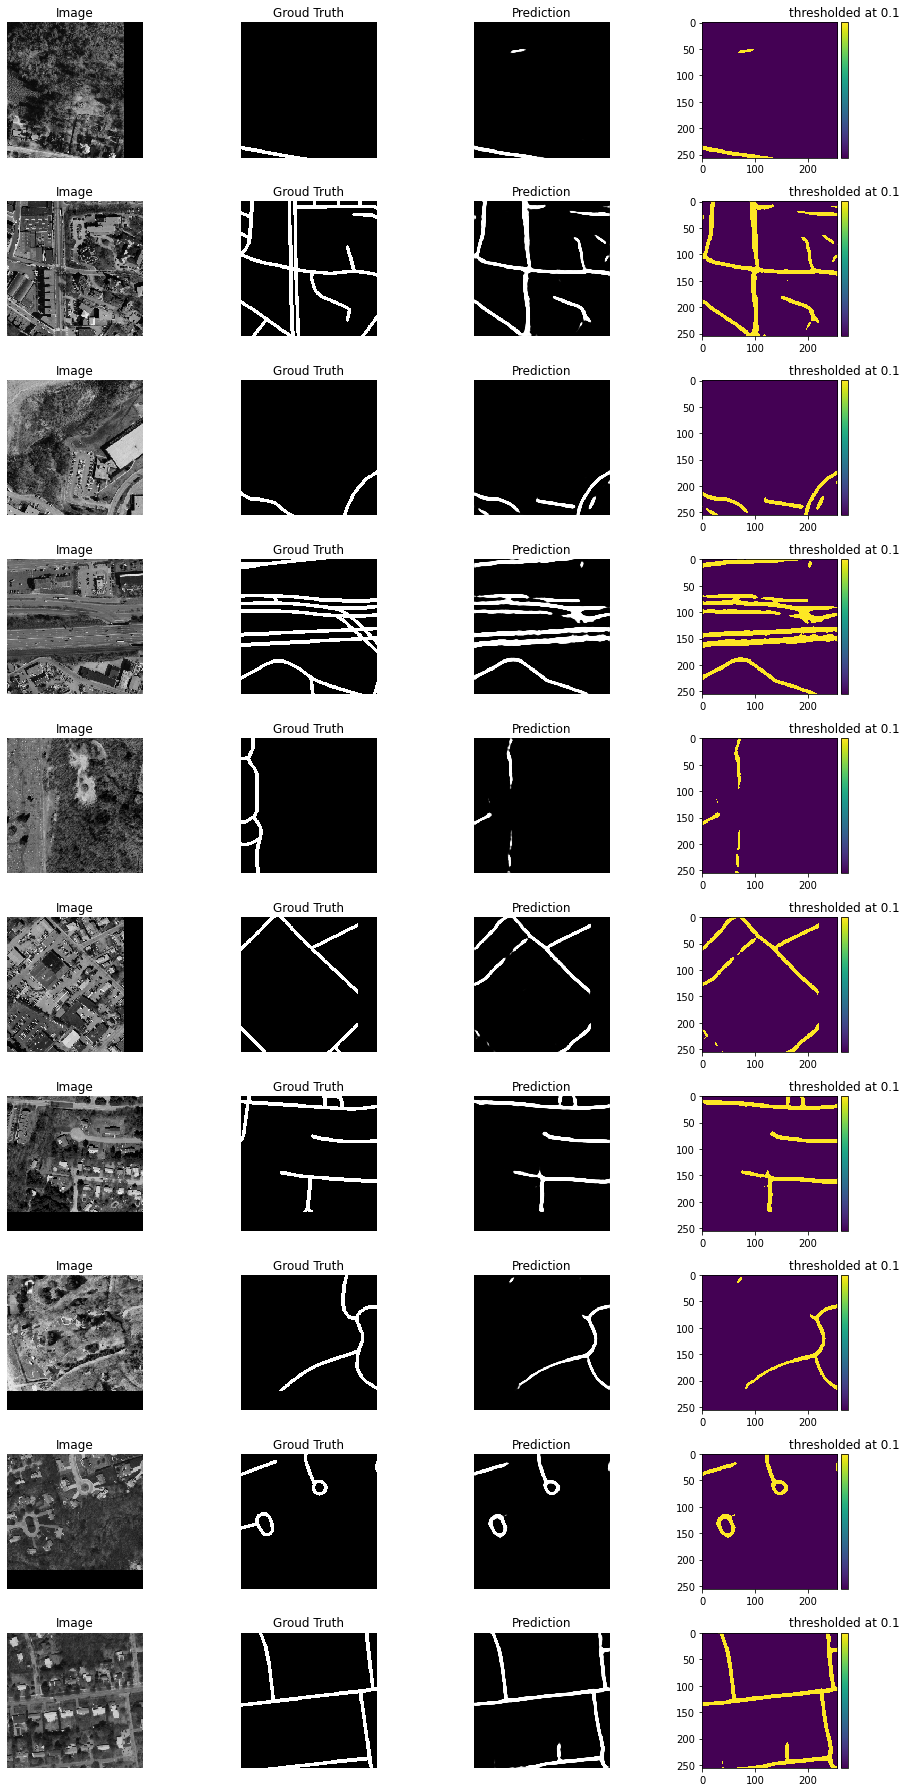

In [70]:
ix = random.randint(0, len(predictions))
num_samples = 10

f = plt.figure(figsize = (15, 25))
for i in range(1, num_samples*4, 4):
  ix = random.randint(0, len(predictions))

  f.add_subplot(num_samples, 4, i)
  imshow(test_images[ix][:,:,0])
  plt.title("Image")
  plt.axis('off')

  f.add_subplot(num_samples, 4, i+1)
  imshow(np.squeeze(test_masks[ix][:,:,0]))
  plt.title("Groud Truth")
  plt.axis('off')

  f.add_subplot(num_samples, 4, i+2)
  imshow(np.squeeze(predictions[ix][:,:,0]))
  plt.title("Prediction")
  plt.axis('off')

  f.add_subplot(num_samples, 4, i+3)
  imshow(np.squeeze(predicton_threshold[ix][:,:,0]))
  plt.title("thresholded at {}".format(thresh_val))
  plt.axis('off')

plt.show()
